In [1]:
## Importing dpendent modules
import tensorflow as tf
import numpy as np
from six.moves import cPickle as pickle
from scipy import ndimage
from PIL import Image
import os
import sys
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import lcn, accuracy
%matplotlib inline

In [15]:
## CLass to create graph and predict

class Network(object):
    def __init__(self, graph):
        try:
            with open('tensorflow_data.pickle', 'rb') as f:
                dataset = pickle.load(f)
                self.train_dataset = dataset['train']['data'].reshape(-1, 32, 32, 1).astype(np.float32)
                self.test_dataset = dataset['test']['data'].reshape(-1, 32, 32, 1).astype(np.float32)
                self.train_labels = dataset['train']['label']
                self.test_labels = dataset['test']['label']
        except Exception as e:
            print('Unable to process data from dataset.pickle', ':', e)
            raise
        self.image_size = 32
        self.n_input_channels = 1
        self.batch_size = 64
        filter_size1 = 5
        filter_size2 = 5
        filter_size3 = 4 
        filter_size4 = 3 
        n_filters1 = 20
        n_filters2 = 40
        n_filters3 = 60
        n_filters4 = 140
        
        outputs_fc1 = 128
        outputs_fc2 = 32
        outputs_fc3 = 11
        parameters_conv = []
        self.conv = []
        self.claf = []
        parameters_conv.append({'filter_size': filter_size1, 'n_filters':n_filters1, 'n_in_filters':1})
        parameters_conv.append({'filter_size': filter_size2, 'n_filters':n_filters2, 'n_in_filters':n_filters1})
        parameters_conv.append({'filter_size': filter_size3, 'n_filters':n_filters3, 'n_in_filters':n_filters2})
        parameters_conv.append({'filter_size': filter_size4, 'n_filters':n_filters4, 'n_in_filters':n_filters3})
        
        
        for index, params in enumerate(parameters_conv):
            with tf.variable_scope('indices' + str(index)) as scope:
                conv_weights = self.new_weights([params['filter_size'], params['filter_size'], params['n_in_filters'], params['n_filters']])
                conv_biases = self.new_biases(length = params['n_filters'])
            self.conv.append({ 'weights': conv_weights, 'biases': conv_biases})
        
        
        for index in range(4):
            with tf.variable_scope('claf'+ str(index)) as scope:
                claf_hidden_weight1 = tf.get_variable( 'h1_weights', shape=[2 * 2 * n_filters4, outputs_fc1],initializer=tf.contrib.layers.xavier_initializer())
                claf_hidden_biases1 = tf.get_variable('h1_biases', initializer=tf.constant(1.0, shape=[outputs_fc1]))
                claf_hidden_weight2 = tf.get_variable( 'h2_weights', shape=[outputs_fc1, outputs_fc2],initializer=tf.contrib.layers.xavier_initializer())
                claf_hidden_biases2 = tf.get_variable('h2_biases', initializer=tf.constant(1.0, shape=[outputs_fc2]))
                claf_out_weights = tf.get_variable( 'o_weights', shape=[outputs_fc2, outputs_fc3],initializer=tf.contrib.layers.xavier_initializer())
                claf_out_biases = tf.get_variable('o_biases', initializer=tf.constant(1.0, shape=[outputs_fc3])) 
            self.claf.append({'h_weights1': claf_hidden_weight1, 'h_biases1': claf_hidden_biases1,'h_weights2': claf_hidden_weight2, 'h_biases2': claf_hidden_biases2, 'o_weights': claf_out_weights, 'o_biases': claf_out_biases})
    
    
    def model(self, data, keep_prob):
        input = data
        logits = []
        input = lcn(input)
        for index, params in enumerate(self.conv):
            with tf.variable_scope('conv' + str(index)) as scope:
                conv = self.new_conv_layer(input, params['weights'], params['biases'])
            input = conv
        input = tf.nn.dropout(input, keep_prob)
        shape = input.get_shape().as_list()
        n_inputs = shape[1] * shape[2] * shape[3]
        layer_flat = tf.reshape(input, [shape[0], n_inputs])
        
        for index, params in enumerate(self.claf):
            with tf.variable_scope('claf' + str(index)) as scope:
                fc = self.new_fc_layer(layer_flat, params['h_weights1'], params['h_biases1'], use_relu= True )
                fc = self.new_fc_layer(fc, params['h_weights2'], params['h_biases2'], use_relu= True )
                logit = self.new_fc_layer(fc, params['o_weights'], params['o_biases'], use_relu= False)
            logits.append(logit)
        return logits

    def new_conv_layer(self, input, weights, biases):
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 2, 2, 1], padding = 'SAME')
        layer += biases
        layer = tf.nn.local_response_normalization(layer)
        layer = tf.nn.relu(layer)
        return layer
    
    def new_fc_layer(self, input, weights, biases,use_relu):
        layer = tf.matmul(input, weights) + biases
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer
    
    def new_weights(self,shape):
        return tf.get_variable("CONV_WEIGHTS", shape=shape)
    
    def new_biases(self,length):
        return tf.Variable(tf.constant(0.05, shape=[length]), name = 'CONV_BIAS')
## Method to generate confusion matrix
    def predict(self, graph):
        ln = self.test_labels.shape[0]
        x = tf.placeholder(tf.float32, shape=(ln, self.image_size, self.image_size, self.n_input_channels))
        with tf.variable_scope('test_pred') as scope:
            logits = self.model(x, 1.0)
            test_prediction = tf.pack([tf.nn.softmax(logits[0]),\
                                       tf.nn.softmax(logits[1]),\
                                       tf.nn.softmax(logits[2]),\
                                       tf.nn.softmax(logits[3])])
            test_prediction = tf.transpose(tf.argmax(test_prediction, 2))
        saver = tf.train.Saver()
        
        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            saver.restore(session, "SVHN_MODEL.ckpt")
            test_prediction = session.run(test_prediction, feed_dict={x: self.test_dataset[:, :, :, :],})
            target_labels = self.test_labels[:, 0:4].reshape([1, 4 * ln])[0]
            target_labels = [int(x) for x in target_labels]
            prediction_labels = test_prediction.reshape([1, 4 * ln])[0]
            with open('pred.pkl', 'wb') as f: pickle.dump([test_prediction, self.test_labels[:, 0:4]], f)
            y_actu = pd.Series(target_labels, name='Actual')
            y_pred = pd.Series(prediction_labels, name='Predicted')
            df_cm = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
            sns.heatmap(df_cm, annot=True)
            
            
## Method to generate labels for sampled 10 images
    def predict_raw(self, graph):
        plt.rcParams['figure.figsize'] = (20.0, 20.0)
        f, ax = plt.subplots(nrows=1, ncols=10)
        x = tf.placeholder(tf.float32, shape=(10, self.image_size, self.image_size, self.n_input_channels))
        with tf.variable_scope('test_pred') as scope:
            logits = self.model(x, 1.0)
            test_prediction = tf.pack([tf.nn.softmax(logits[0]),\
                                       tf.nn.softmax(logits[1]),\
                                       tf.nn.softmax(logits[2]),\
                                       tf.nn.softmax(logits[3])])
            test_prediction = tf.transpose(tf.argmax(test_prediction, 2))
        saver = tf.train.Saver()
        
        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            saver.restore(session, "SVHN_MODEL.ckpt")
            test_prediction = session.run(test_prediction, feed_dict={x: self.test_dataset[10:20,:, :, :],})
            for i, v  in enumerate(test_prediction):    
                house_num = ''
                for x in v:
                    if x != 10:
                        house_num += str(x)
                ax[i].axis('off')
                ax[i].set_title(house_num, loc='center')
                ax[i].imshow(self.test_dataset[i + 10].reshape(32, 32), cmap = 'gray')

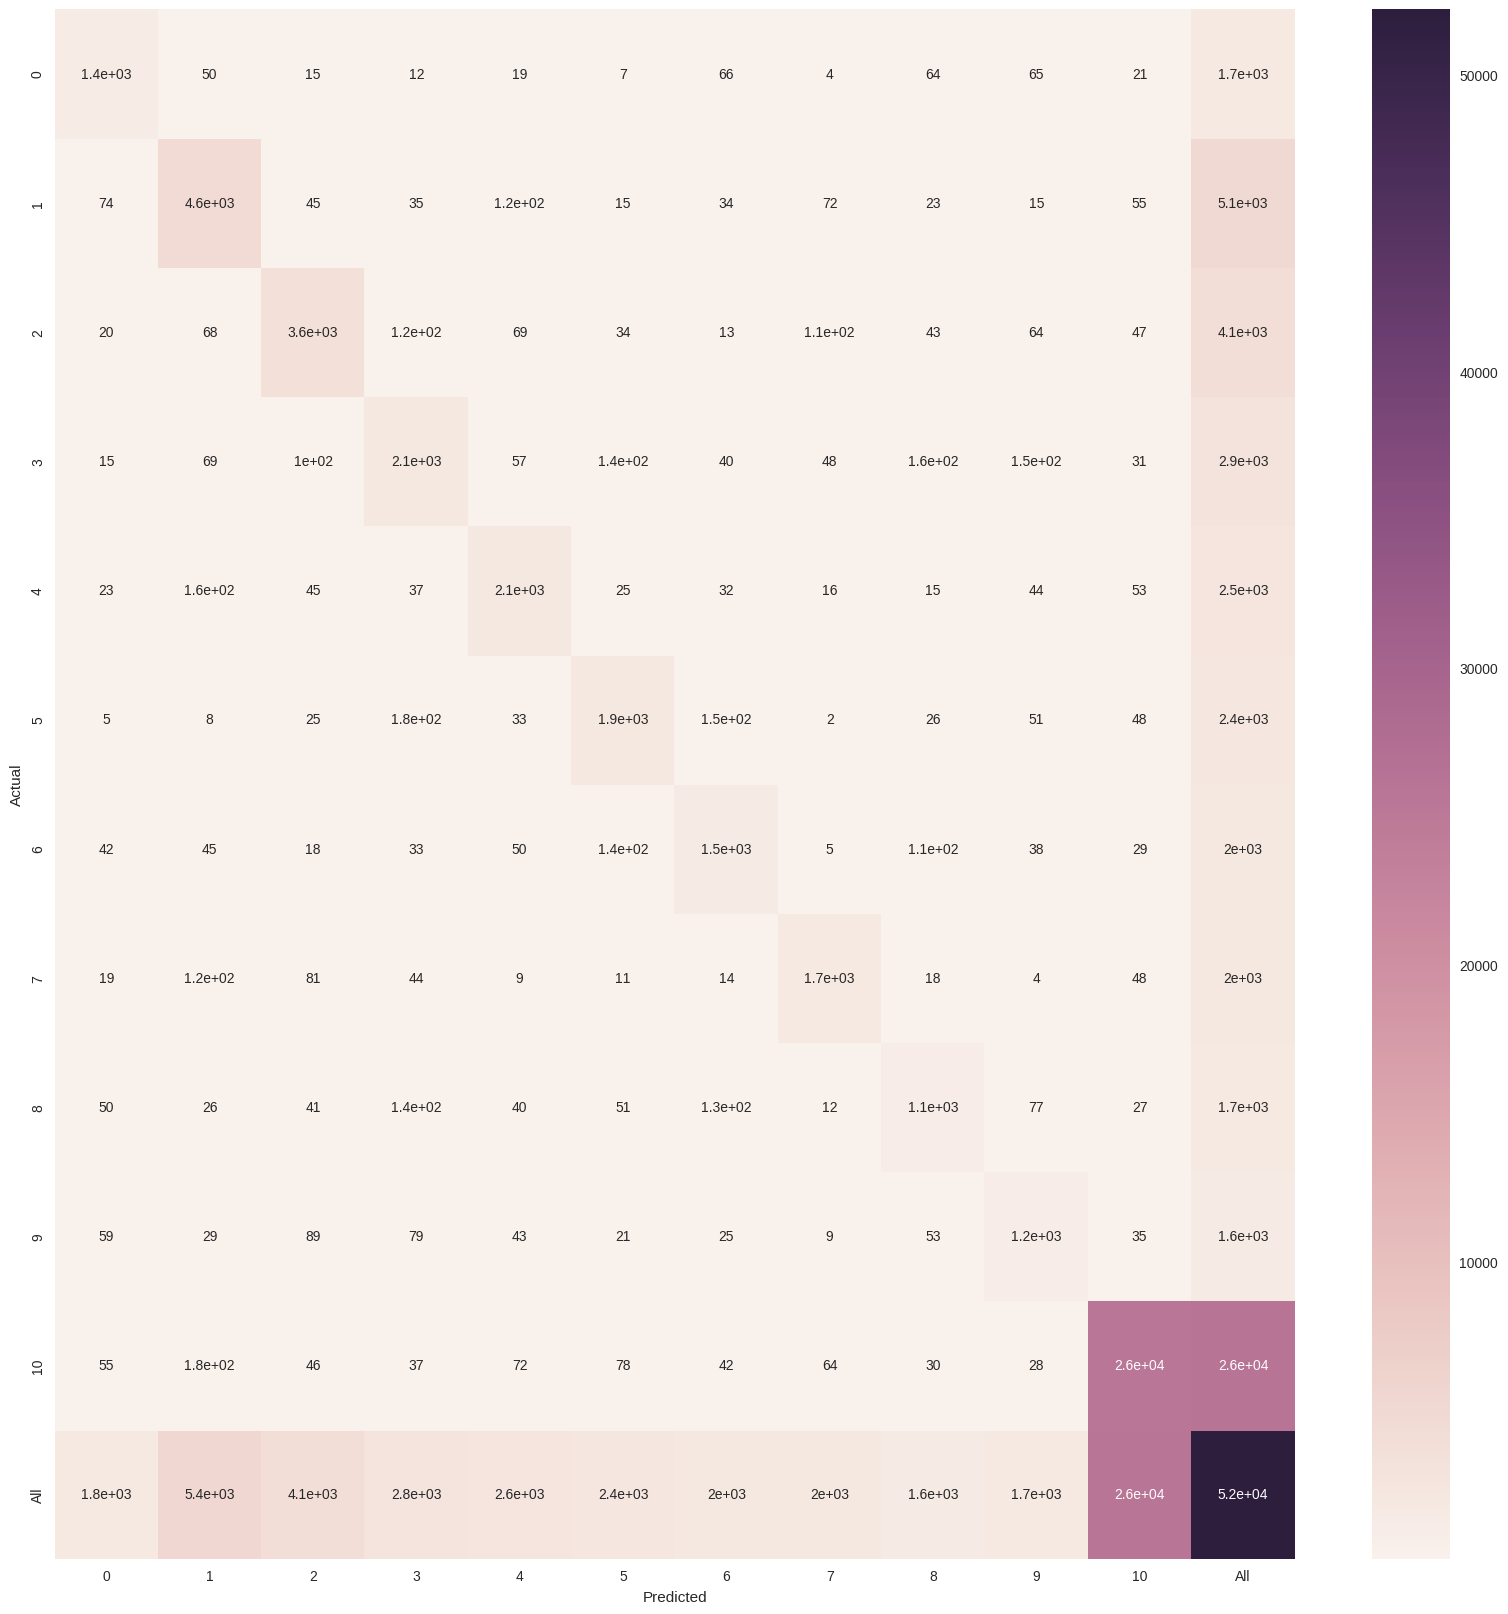

In [16]:
graph = tf.Graph()
with graph.as_default():
    network = Network(graph)
    network.predict(graph)

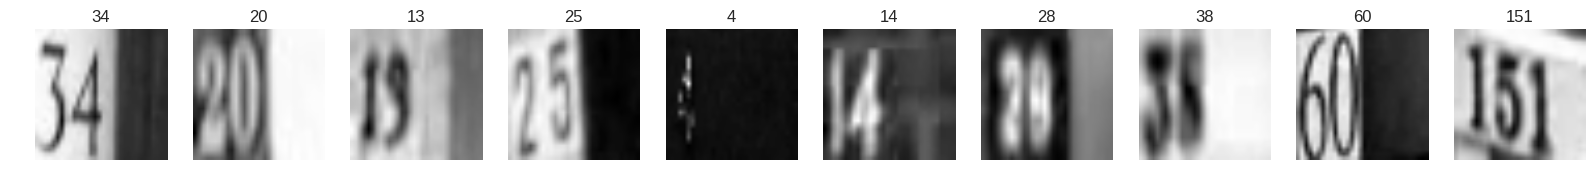

In [10]:
graph = tf.Graph()
with graph.as_default():
    network = Network(graph)  
    network.predict_raw(graph)